# source functions
## Toolbox

In [75]:
print(util.color.BOLD + util.color.BLUE + \
'This contains utility functions' + util.color.END)


kList = [1, 100, 10000]
errList = [0.0, 0.2, 0.5, 1.0]
repList = [1, 2, 3]
size = 12
AList = [0.5]
avgList = [True, False]
    

def func(x, A, k):
    return A * (1-np.exp(-0.479 * 90 * k * x))

def mse(x, y, A, k):
    y_ = func(x, A, k)
    return np.mean((y_-y)**2)

def re(k, A, err, rep, avg, smpl, size):
    return 'k%i_A%.1f_err%.1f_rep%i_avg%i_%s_s%i' %(k, A, err, rep, avg, smpl, size)

This contains utility functions


## Data generation and fitting

Ground truth curve of simulated data


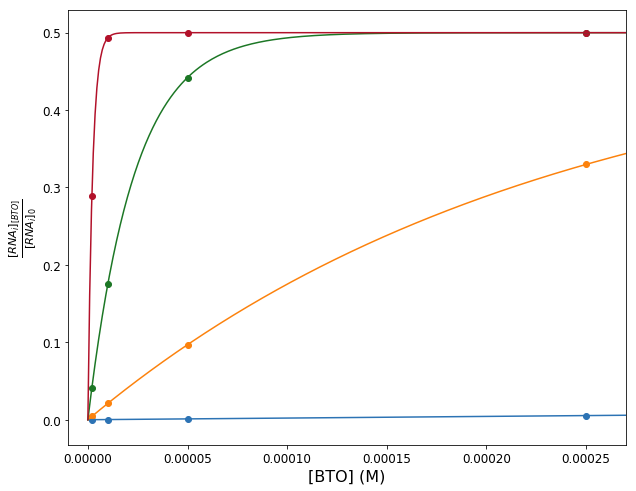

In [114]:
import util
print(util.color.BOLD + util.color.BLUE + \
'Ground truth curve of simulated data' + util.color.END)

import numpy as np
import matplotlib.pyplot as plt


xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])
A = 0.5
kList = [1, 100, 1000, 10000]
fig = plt.figure(figsize=[10,8])
colormap = ['#2C73B4', '#FC820D', '#1C7725', '#B2112A', '#70C7C7']

for ix,k in enumerate(kList):
    ydata = A * (1 - np.exp(-0.479 * 90 * k * xdata))
    plt.scatter(xdata, ydata, facecolors=colormap[ix])
    
    x = np.linspace(0, 0.00027, 300)
    y = A * (1 - np.exp(-0.479 * 90 * k * x))
    plt.plot(x, y, colormap[ix])
    
plt.xlim([-0.00001, 0.00027])
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
plt.ylabel(r'$\frac{[RNA_i]_{[BTO]}}{[RNA_i]_0}$', fontsize=16)
plt.xlabel('[BTO] (M)', fontsize=16)
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/simu_curve.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
print(util.color.BOLD + util.color.BLUE + \
'functions to generate repeated fitting' + util.color.END)

import numpy as np
import util
from scipy.optimize import curve_fit

def random_data_fitting(k, A, err, xTrue, replicate=1, size=1000, average=True):
    # np.random.seed(23)
    
    yTrue = A * (1 - np.exp(-0.479 * 90 * k * xTrue))
    fittingRes = {
        'y_': [],
        'x_': None,
        'k': [],
        'kerr': [],
        'A': [],
        'Aerr': [],
        'kA': [], 
        'kAerr': [],
        'r2': [],
        'mse': [],
        'mseTrue': []
    }
    
    for epochs in range(size):
        
        y = np.array([[np.max([np.random.normal(loc=yt, scale=yt*err), 10e-6]) for yt in yTrue] for _ in range(replicate)])
        x = np.array([xTrue for _ in range(replicate)])
        
        if average:
            y_ = np.mean(y, axis=0)
            x_ = np.mean(x, axis=0)
        else:
            y_ = np.reshape(y, y.shape[0]*y.shape[1])
            x_ = np.reshape(x, x.shape[0]*x.shape[1])
        try:
            initGuess = (np.random.random(), np.random.random())
            popt, pcov = curve_fit(func, x_, y_, method='trf', bounds=([0, 0], [1., np.inf]), p0=initGuess)
        except RuntimeError:
            popt = [0,0]
        
        fittingRes['y_'].append(y_)
        if fittingRes['x_'] is None:
            fittingRes['x_'] = x_
        fittingRes['k'].append(popt[1])
        fittingRes['kerr'].append((popt[1]-k)/k)
        fittingRes['A'].append(popt[0])
        fittingRes['Aerr'].append((popt[0]-A)/A)
        fittingRes['kA'].append(popt[0]*popt[1])
        fittingRes['kAerr'].append((popt[0]*popt[1]-k*A)/(k*A))
    
        y = np.reshape(y, y.shape[0]*y.shape[1])
        x = np.reshape(x, x.shape[0]*x.shape[1])
        
        res = y - (1-np.exp(-0.479 * 90 * popt[1] * x)) * popt[0]
        ss_res = np.sum(res**2)
        ss_tot = np.sum((y-np.mean(y))**2)
        fittingRes['r2'].append(1-ss_res/ss_tot)
        
        fittingRes['mse'].append(mse(x_, y_, A=popt[0], k=popt[1]))
        fittingRes['mseTrue'].append(mse(x_, y_, A=A, k=k))
        
        if epochs%10 == 0:
            util.progress_bar(epochs/size)

    return fittingRes


functions to generate repeated fitting


# Error rate in experimental condition

In [82]:
print(util.color.BOLD + util.color.BLUE + \
'Show error rate of simulated data similar to experimental condition' + util.color.END)

AList = [0.2, 0.5, 0.8]
kList = [1, 100, 10000]
errList = [0.0, 0.2, 0.5, 1.0]
repList = [3]
smplList = ['lin', 'log', 'revlog']
size = 12

if __name__=='__main__':
    
    fittingResults = {}
    
    for A in AList:
        for k in kList:
            for err in errList:
                for rep in repList:
                    x = np.array([0.00025, 0.00005, 0.00001, 0.000002])
                    sample = re(k=k, A=A, err=err, rep=rep, avg=True, smpl='exp', size=12)
                    print('Calculating %s ...' %sample)
                    fittingResults[sample] = random_data_fitting(k, A, err, x, replicate=3)

    util.dump_pickle(fittingResults, '/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/simu_exp_NEW.pkl',
                 log="A collection of simulated data, with different k, A, error, at experimental sampling condition, with inital fitting k, A in random()")

Show error rate of simulated data similar to experimental condition
Calculating k1_A0.2_err0.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k1_A0.2_err0.2_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k1_A0.2_err0.5_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k1_A0.2_err1.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k100_A0.2_err0.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k100_A0.2_err0.2_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k100_A0.2_err0.5_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k100_A0.2_err1.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k10000_A0.2_err0.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k10000_A0.2_err0.2_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k10000_A0.2_err0.5_rep3_avg1_exp_s12 ...
[====================] 99%Calculating k10000_A0.2_err1.0_rep3_avg1_exp_s12 ...
[====================] 99%Calculat

Boxplot for sampling methods
simu_exp_NEW.pkl:
A collection of simulated data, with different k, A, error, at experimental sampling condition, with inital fitting k, A in random()


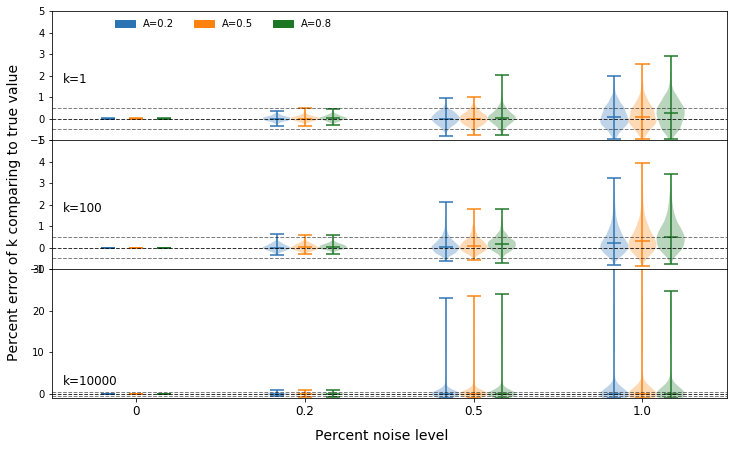

In [85]:
print(util.color.BOLD + util.color.BLUE + \
'Boxplot for sampling methods' + util.color.END)

def box_plot(fittingResults, param=2):
    import matplotlib.pyplot as plt
    
    def set_colors(bp, c):
        from matplotlib.pyplot import setp
        setp(bp['boxes'][0], color=c)
        setp(bp['caps'][0], color=c)
        setp(bp['caps'][1], color=c)
        setp(bp['whiskers'][0], color=c)
        setp(bp['whiskers'][1], color=c)
        setp(bp['fliers'][0], markerfacecolor=c, marker='*', markersize=5, alpha=0.3)
        # setp(bp['fliers'][1], color=c, alpha=0.3)
        setp(bp['medians'][0], color='w')
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [100, 10, 3]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            bp1 = ax[kIx].boxplot(fittingResults[re(k, AList[0], err, rep=3, avg=1, smpl='exp', size=12 )][param+'err'], 
                                 positions=[3*errIx+1], widths = 0.4, notch=1, bootstrap=1000, patch_artist=True)
            set_colors(bp1, '#2C73B4')
            bp2 = ax[kIx].boxplot(fittingResults[re(k, AList[1], err, rep=3, avg=1, smpl='exp', size=12 )][param+'err'], 
                                 positions=[3*errIx+1.5], widths = 0.4, notch=1, bootstrap=1000, patch_artist=True)
            set_colors(bp2, '#FC820D')
            bp3 = ax[kIx].boxplot(fittingResults[re(k, AList[2], err, rep=3, avg=1, smpl='exp', size=12 )][param+'err'], 
                                 positions=[3*errIx+2], widths = 0.4, notch=1, bootstrap=1000, patch_artist=True)
            set_colors(bp3, '#1C7725')
            
        ax[kIx].set_xlim([0, 12])
        # ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],
                           ['A=0.2', 'A=0.5', 'A=0.8'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    # ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    # ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    # ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of kA comparing to true value', x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/replicate_even_box_kA.jpeg', dpi=300, bbox_inches='tight')
    plt.show()

    
def violin_plot(fittingResults, param=2):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    def set_colors(vp, c):
        for ix, pc in enumerate(vp['bodies']):
            pc.set_facecolor(c)
        vp['cbars'].set_edgecolor(c)
        vp['cmins'].set_edgecolor(c)
        vp['cmaxes'].set_edgecolor(c)
        vp['cmedians'].set_edgecolor(c)
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [5, 5, 30]
    legendHandles = [mpatches.Patch(color='#2C73B4'), mpatches.Patch(color='#FC820D'), mpatches.Patch(color='#1C7725')]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            vp1 = ax[kIx].violinplot(fittingResults[re(k, AList[0], err, rep=3, avg=1, smpl='exp', size=12)][param+'err'],
                                    positions=[3*errIx+1], showmedians=True)
            set_colors(vp1, '#2C73B4')
            vp2 = ax[kIx].violinplot(fittingResults[re(k, AList[1], err, rep=3, avg=1, smpl='exp', size=12)][param+'err'],
                                    positions=[3*errIx+1.5], showmedians=True)
            set_colors(vp2, '#FC820D')
            vp3 = ax[kIx].violinplot(fittingResults[re(k, AList[2], err, rep=3, avg=1, smpl='exp', size=12)][param+'err'],
                                    positions=[3*errIx+2], showmedians=True)
            set_colors(vp3, '#1C7725')
        
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend(legendHandles,
                           ['A=0.2', 'A=0.5', 'A=0.8'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    # ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    # ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    # ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of k comparing to true value', x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/simu_exp_k_err_zoomed.jpeg', dpi=300, bbox_inches='tight')
    plt.show()
    

    
AList = [0.2, 0.5, 0.8]
kList = [1, 100, 10000]
errList = [0.0, 0.2, 0.5, 1.0]
repList = [3]
smplList = ['exp']
size = 12   

fittingResults = util.load_pickle('/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/simu_exp_NEW.pkl')
# box_plot(fittingResults, param='k')
violin_plot(fittingResults, param='kA')

## Geometry of estimated k, A
**See local minima part**

# Sampling strategy

## Use replicates or dense sample

Investigate the tradeoffs between replicates (directly fit or average then fit) and dense sampling, <br>
with same number of sample points (12), at different noise level (0, 0.2, 0.5, 1.0) <br>

** Data are imported instead of calculating in this notebook**

In [401]:
print(util.color.BOLD + util.color.BLUE + \
'Generate simulated data for sampling strategy analysis' + util.color.END)

if __name__=='__main__':
    
    fittingResults = {}
    kList = [1, 100, 10000]
    errList = [0.0, 0.2, 0.5, 1.0]
    repList = [1, 2, 3]
    size = 12
    AList = [0.5]
    avgList = [True, False]
    
    for A in AList:
        for k in kList:
            for err in errList:
                for rep in repList:
                    for avg in avgList:
                        x = np.linspace(0, 0.00025, int(size/rep)+1)[1:]
                        sample = re(k=k, A=A, err=err, rep=rep, avg=avg, smpl='lin', size=size)
                        print('Calculating %s ...' %sample)
                        fittingResults[sample] = random_data_fitting(k, A, err, x, average=avg, replicate=rep)
                    
                        x = np.logspace(-6, np.log10(0.00025), int(size/rep))
                        sample = re(k=k, A=A, err=err, rep=rep, avg=avg, smpl='log', size=size)
                        print('Calculating %s ...' %sample)
                        fittingResults[sample] = random_data_fitting(k, A, err, x, average=avg, replicate=rep)
                        
                        x = 2.5*10**-4+10**-6 - np.logspace(np.log10(0.000001), np.log10(0.00025), 4)
                        sample = re(k=k, A=A, err=err, rep=rep, avg=avg, smpl='revlog', size=size)
                        print('Calculating %s ...' %sample)
                        fittingResults[sample] = random_data_fitting(k, A, err, x, average=avg, replicate=rep)
    
    util.dump_pickle(fittingResults, '/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/smlp_strategy.pkl',
                    log='this is sumulated data containing combinatorial samples of different k, err, rep, average and sampling interval')

Generate simulated data for sampling strategy analysis
Calculating k1_A0.5_err0.0_rep1_avg1_lin_s12 ...
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg1_log_s12 ...
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg1_revlog_s12 ...
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_lin_s12 ...
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s12 ...
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_revlog_s12 ...
[=================== ] 96%

KeyboardInterrupt: 

In [115]:
import util
fittingResults = util.load_pickle('/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/smlp_strategy_2.pkl')

smlp_strategy_2.pkl:
this is sumulated data containing combinatorial samples of different k, err, rep, average and sampling interval, repeated


Boxplot for dense sampling or replicates, linear sampling


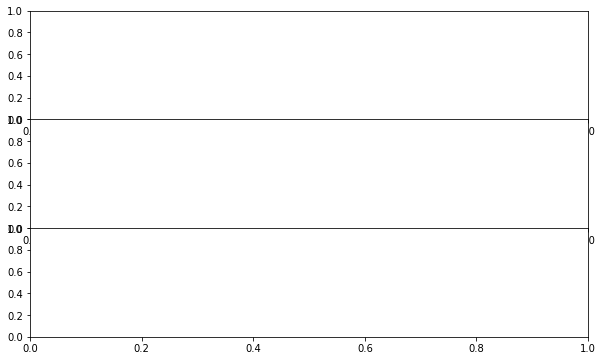

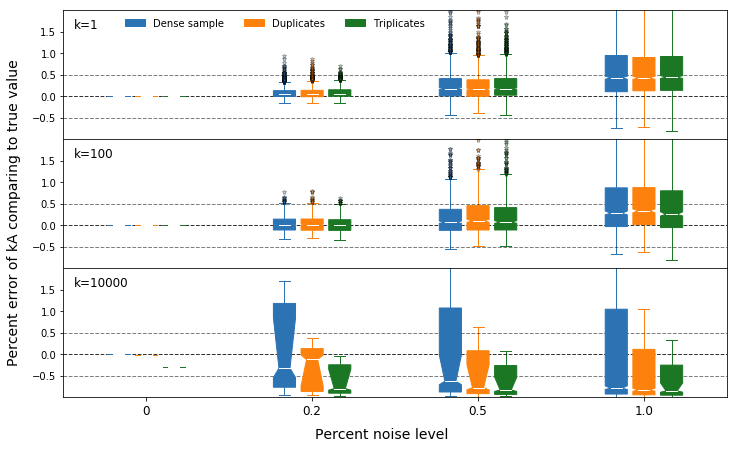

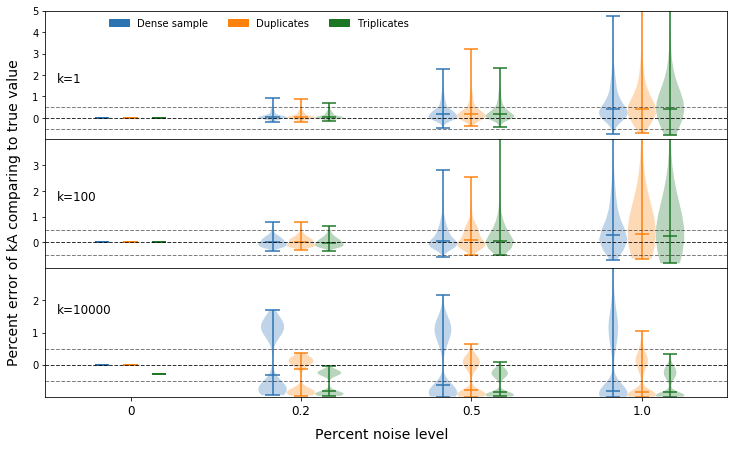

In [70]:
print(util.color.BOLD + util.color.BLUE + \
'Boxplot for dense sampling or replicates, linear sampling' + util.color.END)

def box_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    
    def set_colors(bp, c):
        from matplotlib.pyplot import setp
        setp(bp['boxes'][0], color=c)
        setp(bp['caps'][0], color=c)
        setp(bp['caps'][1], color=c)
        setp(bp['whiskers'][0], color=c)
        setp(bp['whiskers'][1], color=c)
        setp(bp['fliers'][0], markerfacecolor=c, marker='*', markersize=5, alpha=0.3)
        # setp(bp['fliers'][1], color=c, alpha=0.3)
        setp(bp['medians'][0], color='w')
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            bp1 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=1, size=12, smpl='lin')][param + 'err'], 
                                 positions=[3*errIx+1], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp1, '#2C73B4')
            bp2 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=2, size=12, smpl='lin')][param + 'err'], 
                                 positions=[3*errIx+1.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp2, '#FC820D')
            bp3 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='lin')][param + 'err'], 
                                 positions=[3*errIx+2], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp3, '#1C7725')
            
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, 2])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],
                           ['Dense sample', 'Duplicates', 'Triplicates'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value' %param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/replicate_lin_box_%s.jpeg'%param, dpi=300, bbox_inches='tight')
    plt.show()

    
def violin_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    def set_colors(vp, c):
        for ix, pc in enumerate(vp['bodies']):
            pc.set_facecolor(c)
        vp['cbars'].set_edgecolor(c)
        vp['cmins'].set_edgecolor(c)
        vp['cmaxes'].set_edgecolor(c)
        vp['cmedians'].set_edgecolor(c)
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [5, 4, 3]
    legendHandles = [mpatches.Patch(color='#2C73B4'), mpatches.Patch(color='#FC820D'), mpatches.Patch(color='#1C7725')]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            vp1 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=1, avg=False, smpl='lin', size=12)][param+'err'],
                                    positions=[3*errIx+1], showmedians=True)
            set_colors(vp1, '#2C73B4')
            vp2 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=2, avg=False, smpl='lin', size=12)][param+'err'],
                                    positions=[3*errIx+1.5], showmedians=True)
            set_colors(vp2, '#FC820D')
            vp3 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='lin', size=12)][param+'err'],
                                    positions=[3*errIx+2], showmedians=True)
            set_colors(vp3, '#1C7725')
        
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend(legendHandles,
                           ['Dense sample', 'Duplicates', 'Triplicates'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([0, 1, 2, 3, 4, 5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([0, 1, 2, 3])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([0, 1, 2])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value'%param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/replicate_lin_violin_%s.jpeg' %param, dpi=300, bbox_inches='tight')
    plt.show()    
    

box_plot(fittingResults, param='kA')
violin_plot(fittingResults, param='kA')

Boxplot for dense sampling or replicates, log sampling


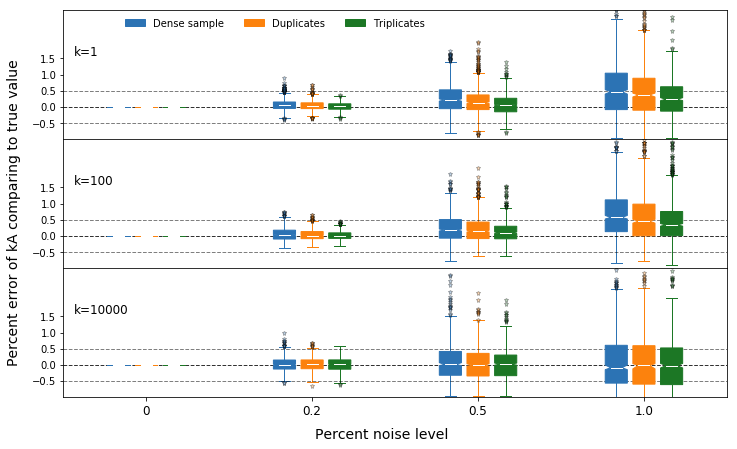

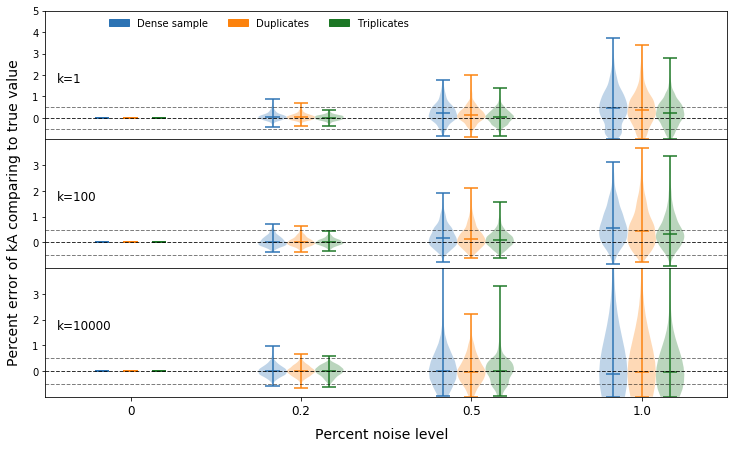

In [71]:
print(util.color.BOLD + util.color.BLUE + \
'Boxplot for dense sampling or replicates, log sampling' + util.color.END)

def box_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    
    def set_colors(bp, c):
        from matplotlib.pyplot import setp
        setp(bp['boxes'][0], color=c)
        setp(bp['caps'][0], color=c)
        setp(bp['caps'][1], color=c)
        setp(bp['whiskers'][0], color=c)
        setp(bp['whiskers'][1], color=c)
        setp(bp['fliers'][0], markerfacecolor=c, marker='*', markersize=5, alpha=0.3)
        # setp(bp['fliers'][1], color=c, alpha=0.3)
        setp(bp['medians'][0], color='w')
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            bp1 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=1, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+1], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp1, '#2C73B4')
            bp2 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=2, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+1.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp2, '#FC820D')
            bp3 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+2], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp3, '#1C7725')
            
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, 3])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]],
                           ['Dense sample', 'Duplicates', 'Triplicates'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value' %param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/replicate_log_box_%s.jpeg'%param, dpi=300, bbox_inches='tight')
    plt.show()

    
def violin_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    def set_colors(vp, c):
        for ix, pc in enumerate(vp['bodies']):
            pc.set_facecolor(c)
        vp['cbars'].set_edgecolor(c)
        vp['cmins'].set_edgecolor(c)
        vp['cmaxes'].set_edgecolor(c)
        vp['cmedians'].set_edgecolor(c)
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [5, 4, 4]
    legendHandles = [mpatches.Patch(color='#2C73B4'), mpatches.Patch(color='#FC820D'), mpatches.Patch(color='#1C7725')]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            vp1 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=1, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+1], showmedians=True)
            set_colors(vp1, '#2C73B4')
            vp2 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=2, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+1.5], showmedians=True)
            set_colors(vp2, '#FC820D')
            vp3 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+2], showmedians=True)
            set_colors(vp3, '#1C7725')
        
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend(legendHandles,
                           ['Dense sample', 'Duplicates', 'Triplicates'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=3, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([0, 1, 2, 3, 4, 5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([0, 1, 2, 3])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([0, 1, 2, 3])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value'%param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/replicate_log_violin_%s.jpeg' %param, dpi=300, bbox_inches='tight')
    plt.show()    
    

box_plot(fittingResults, param='kA')
violin_plot(fittingResults, param='kA')

## Average to fit or direct fit

In [ ]:
print(util.color.BOLD + util.color.BLUE + \
'Test average and fitting direction on evenly distributed sampling interval' + util.color.END)

A = 0.5
kList = [1, 100, 10000]

if __name__=='__main__':
    
    fittedParamL = {}
    A = 0.5
    kList = [1, 100, 10000]
    errList = [0.0, 0.2, 0.5, 1.0]
    
    for k in kList:
        for err in errList:
            x = np.linspace(0, 0.00025, 7)[1:]
            print('Calculating k%i_A%.1f_err%.1f_rep%i' %(k, A, err, 2))
            fittedParamL['k%i_A%.1f_err%.1f_rep%i' %(k, A, err, 2)] = random_data_fitting(k, A, err, x, replicate=2, 
                                                                                          pctErr=True)
            x = np.linspace(0, 0.00025, 7)[1:]
            print('Calculating k%i_A%.1f_err%.1f_rep%i_na' %(k, A, err, 2))
            fittedParamL['k%i_A%.1f_err%.1f_rep%i_na' %(k, A, err, 2)] = random_data_fitting(k, A, err, x, replicate=2, 
                                                                                             average=False, pctErr=True)
            x = np.linspace(0, 0.00025, 5)[1:]
            print('Calculating k%i_A%.1f_err%.1f_rep%i' %(k, A, err, 3))
            fittedParamL['k%i_A%.1f_err%.1f_rep%i' %(k, A, err, 3)] = random_data_fitting(k, A, err, x, replicate=3,
                                                                                         pctErr=True)
            x = np.linspace(0, 0.00025, 5)[1:]
            print('Calculating k%i_A%.1f_err%.1f_rep%i_na' %(k, A, err, 3))
            fittedParamL['k%i_A%.1f_err%.1f_rep%i_na' %(k, A, err, 3)] = random_data_fitting(k, A, err, x, replicate=3, 
                                                                                             average=False, pctErr=True)
    

Boxplot for direct fitting or average then fit, log sampling


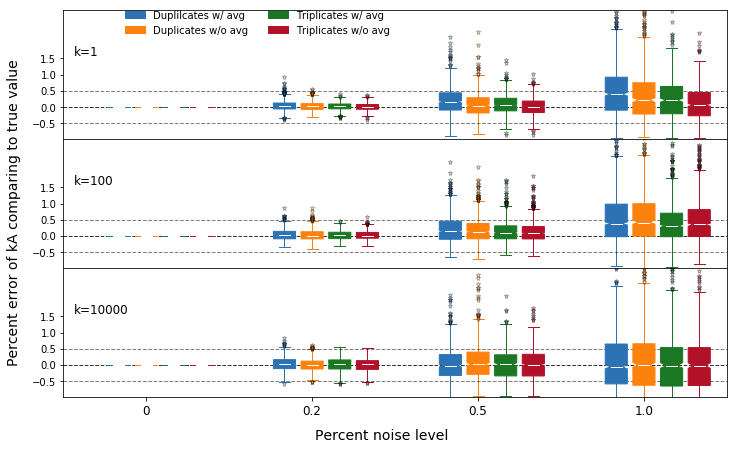

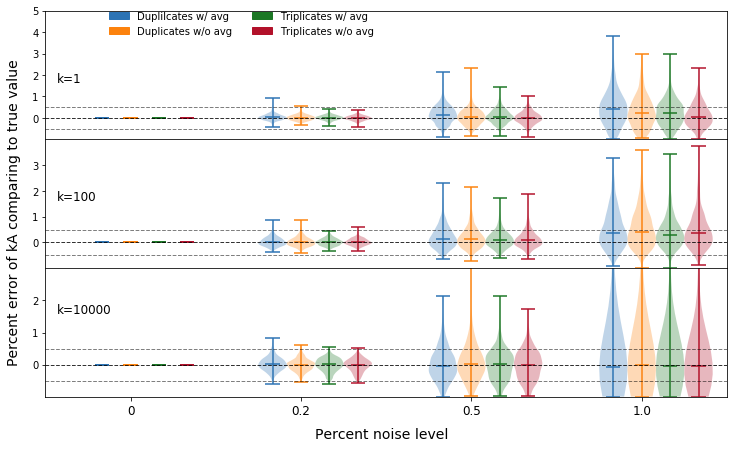

In [30]:
print(util.color.BOLD + util.color.BLUE + \
'Boxplot for direct fitting or average then fit, log sampling' + util.color.END)

def box_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    
    def set_colors(bp, c):
        from matplotlib.pyplot import setp
        setp(bp['boxes'][0], color=c)
        setp(bp['caps'][0], color=c)
        setp(bp['caps'][1], color=c)
        setp(bp['whiskers'][0], color=c)
        setp(bp['whiskers'][1], color=c)
        setp(bp['fliers'][0], markerfacecolor=c, marker='*', markersize=5, alpha=0.3)
        # setp(bp['fliers'][1], color=c, alpha=0.3)
        setp(bp['medians'][0], color='w')
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            bp1 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=2, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+1], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp1, '#2C73B4')
            bp2 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=True, rep=2, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+1.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp2, '#FC820D')
            bp3 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+2], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp3, '#1C7725')
            bp4 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=True, rep=3, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+2.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp4, '#B2112A')
            
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, 3])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]],
                           ['Duplilcates w/ avg', 'Duplicates w/o avg', 
                            'Triplicates w/ avg', 'Triplicates w/o avg'],
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=2, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value' %param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/avg_log_box_%s.jpeg'%param, dpi=300, bbox_inches='tight')
    plt.show()

    
def violin_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    def set_colors(vp, c):
        for ix, pc in enumerate(vp['bodies']):
            pc.set_facecolor(c)
        vp['cbars'].set_edgecolor(c)
        vp['cmins'].set_edgecolor(c)
        vp['cmaxes'].set_edgecolor(c)
        vp['cmedians'].set_edgecolor(c)
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [5, 4, 3]
    legendHandles = [mpatches.Patch(color='#2C73B4'), mpatches.Patch(color='#FC820D'), 
                     mpatches.Patch(color='#1C7725'), mpatches.Patch(color='#B2112A')]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            vp1 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=2, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+1], showmedians=True)
            set_colors(vp1, '#2C73B4')
            vp2 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=2, avg=True, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+1.5], showmedians=True)
            set_colors(vp2, '#FC820D')
            vp3 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+2], showmedians=True)
            set_colors(vp3, '#1C7725')
            vp4 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=True, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+2.5], showmedians=True)
            set_colors(vp4, '#B2112A')
        
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend(legendHandles,
                           ['Duplilcates w/ avg', 'Duplicates w/o avg', 
                            'Triplicates w/ avg', 'Triplicates w/o avg'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=2, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([0, 1, 2, 3, 4, 5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([0, 1, 2, 3])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([0, 1, 2])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value'%param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/avg_log_violin_%s.jpeg' %param, dpi=300, bbox_inches='tight')
    plt.show()    
    

box_plot(fittingResults, param='kA')
violin_plot(fittingResults, param='kA')

## Sampling eveness

In [50]:
print(util.color.BOLD + util.color.BLUE + \
'Add experimental sampling' + util.color.END)

A = 0.5
kList = [1, 100, 10000]

if __name__=='__main__':
    
    A = 0.5
    kList = [1, 100, 10000]
    errList = [0.0, 0.2, 0.5, 1.0]
    
    for k in kList:
        for err in errList:
            x = np.array([0.00025, 0.00005, 0.00001, 0.000002])
            sample = re(A=0.5, avg=0, err=err, k=k, rep=3, size=12, smpl='exp')
            print('Calculating %s' %sample)
            fittingResults[sample] = random_data_fitting(k, A, err, x, average=False, replicate=3)


Add experimental sampling
Calculating k1_A0.5_err0.0_rep3_avg0_exp_s12
[====================] 99%Calculating k1_A0.5_err0.2_rep3_avg0_exp_s12
[====================] 99%Calculating k1_A0.5_err0.5_rep3_avg0_exp_s12
[====================] 99%Calculating k1_A0.5_err1.0_rep3_avg0_exp_s12
[====================] 99%Calculating k100_A0.5_err0.0_rep3_avg0_exp_s12
[====================] 99%Calculating k100_A0.5_err0.2_rep3_avg0_exp_s12
[====================] 99%Calculating k100_A0.5_err0.5_rep3_avg0_exp_s12
[====================] 99%Calculating k100_A0.5_err1.0_rep3_avg0_exp_s12
[====================] 99%Calculating k10000_A0.5_err0.0_rep3_avg0_exp_s12
[====================] 99%Calculating k10000_A0.5_err0.2_rep3_avg0_exp_s12
[====================] 99%Calculating k10000_A0.5_err0.5_rep3_avg0_exp_s12
[====================] 99%Calculating k10000_A0.5_err1.0_rep3_avg0_exp_s12
[====================] 99%

Plots on sampling interval


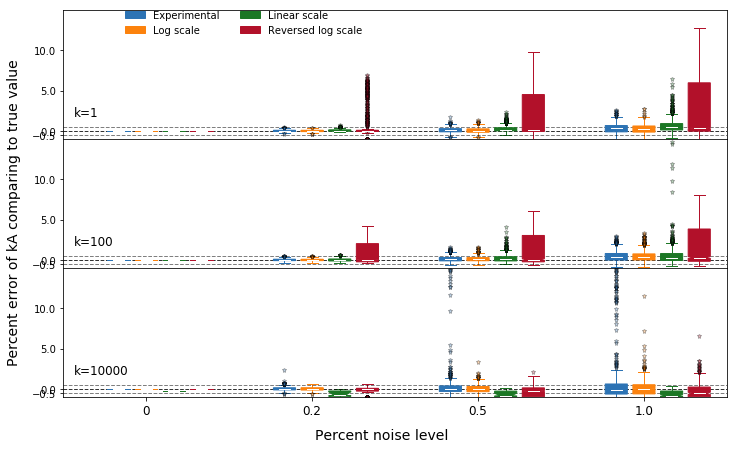

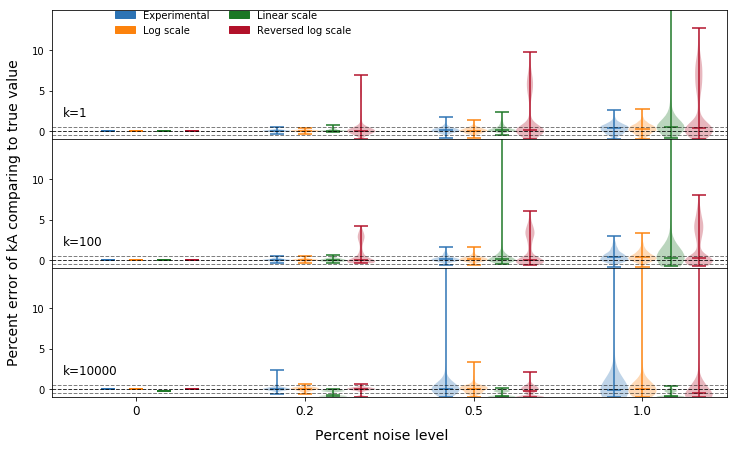

In [55]:
print(util.color.BOLD + util.color.BLUE + \
'Plots on sampling interval' + util.color.END)

def box_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    
    def set_colors(bp, c):
        from matplotlib.pyplot import setp
        setp(bp['boxes'][0], color=c)
        setp(bp['caps'][0], color=c)
        setp(bp['caps'][1], color=c)
        setp(bp['whiskers'][0], color=c)
        setp(bp['whiskers'][1], color=c)
        setp(bp['fliers'][0], markerfacecolor=c, marker='*', markersize=5, alpha=0.3)
        # setp(bp['fliers'][1], color=c, alpha=0.3)
        setp(bp['medians'][0], color='w')
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            bp1 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='exp')][param + 'err'], 
                                 positions=[3*errIx+1], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp1, '#2C73B4')
            bp2 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='log')][param + 'err'], 
                                 positions=[3*errIx+1.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp2, '#FC820D')
            bp3 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='lin')][param + 'err'], 
                                 positions=[3*errIx+2], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp3, '#1C7725')
            bp4 = ax[kIx].boxplot(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=3, size=12, smpl='revlog')][param + 'err'], 
                                 positions=[3*errIx+2.5], widths = 0.4, notch=1, bootstrap=10000, patch_artist=True)
            set_colors(bp4, '#B2112A')
            
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, 15])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]],
                           ['Experimental', 'Log scale', 
                            'Linear scale', 'Reversed log scale'],
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=2, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([-0.5, 0, 5, 10])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([-0.5, 0, 5, 10])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([-0.5, 0, 5, 10])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value' %param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/smpl_box_%s.jpeg'%param, dpi=300, bbox_inches='tight')
    plt.show()

    
def violin_plot(fittingResults, param='kA'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    def set_colors(vp, c):
        for ix, pc in enumerate(vp['bodies']):
            pc.set_facecolor(c)
        vp['cbars'].set_edgecolor(c)
        vp['cmins'].set_edgecolor(c)
        vp['cmaxes'].set_edgecolor(c)
        vp['cmedians'].set_edgecolor(c)
    
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    
    ylimList = [15, 15, 15]
    legendHandles = [mpatches.Patch(color='#2C73B4'), mpatches.Patch(color='#FC820D'), 
                     mpatches.Patch(color='#1C7725'), mpatches.Patch(color='#B2112A')]
    
    for kIx,k in enumerate(kList):
        for errIx, err in enumerate(errList):
            vp1 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='exp', size=12)][param+'err'],
                                    positions=[3*errIx+1], showmedians=True)
            set_colors(vp1, '#2C73B4')
            vp2 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='log', size=12)][param+'err'],
                                    positions=[3*errIx+1.5], showmedians=True)
            set_colors(vp2, '#FC820D')
            vp3 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='lin', size=12)][param+'err'],
                                    positions=[3*errIx+2], showmedians=True)
            set_colors(vp3, '#1C7725')
            vp4 = ax[kIx].violinplot(fittingResults[re(k, 0.5, err, rep=3, avg=False, smpl='revlog', size=12)][param+'err'],
                                    positions=[3*errIx+2.5], showmedians=True)
            set_colors(vp4, '#B2112A')
        
        ax[kIx].set_xlim([0, 12])
        ax[kIx].set_ylim([-1, ylimList[kIx]])
        ax[kIx].plot([0, 12], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [-0.5, -0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].plot([0, 12], [0, 0], 'k--', alpha=0.8, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=0.2, y=1.5, ha='left', va='bottom', fontsize=12)
        
        if kIx==0:
            ax[kIx].legend(legendHandles,
                           ['Experimental', 'Log scale', 
                            'Linear scale', 'Reversed log scale'], 
                           bbox_to_anchor=(0.08, 0.9), loc='center left',ncol=2, frameon=False)
    
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[0].set_yticks([0, 5, 10])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([0, 5, 10])
    xloc = [1.5, 4.5, 7.5, 10.5]
    ax[2].set_xticks(xloc)
    ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    ax[2].set_yticks([0, 5, 10])
    
    fig.text(s='Percent noise level', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error of %s comparing to true value'%param, x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/smpl_violin_%s.jpeg' %param, dpi=300, bbox_inches='tight')
    plt.show()    
    

box_plot(fittingResults, param='kA')
violin_plot(fittingResults, param='kA')

## Sampling size

In [11]:
print(util.color.BOLD + util.color.BLUE + \
'Test sampling eveness' + util.color.END)

A = 0.5
kList = [1, 100, 10000]

if __name__=='__main__':
    
    A = 0.5
    kList = [1, 100, 10000]
    errList = [0.0, 0.2, 0.5, 1.0]
    sizeList = [i for i in range(50) if i>=1]
    rep = 1
    
    for k in kList:
        for err in errList:
            for size in sizeList:
                x = np.logspace(np.log10(0.000001), np.log10(0.00025), size)
                sample = re(A=A, k=k, err=err, avg=False, rep=1, size=size, smpl='log')
                print('Calculating %s' %sample)
                fittingResults[sample] = random_data_fitting(k, A, err, x, average=False, replicate=1)
                
                
        

Test sampling eveness
Calculating k1_A0.5_err0.0_rep1_avg0_log_s1
[======              ] 32%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars


[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s2
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s3
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s4
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s5
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s6
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s7
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s8
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s9
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s10
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s11
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s12
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s13
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s14
[====================] 99%Calculating k1_A0.5_err0.0_rep1_avg0_log_s15
[=============

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in double_scalars


[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s2
[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s3
[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s4
[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s5
[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s6
[====================] 99%Calculating k1_A0.5_err0.2_rep1_avg0_log_s7
[=============       ] 67%

KeyboardInterrupt: 

In [12]:
fittingResults = util.load_pickle('/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/smlp_num.pkl')

smlp_num.pkl:
this is sumulated data of different number of samples varies on k, err, rep


Boxplot for sampling methods


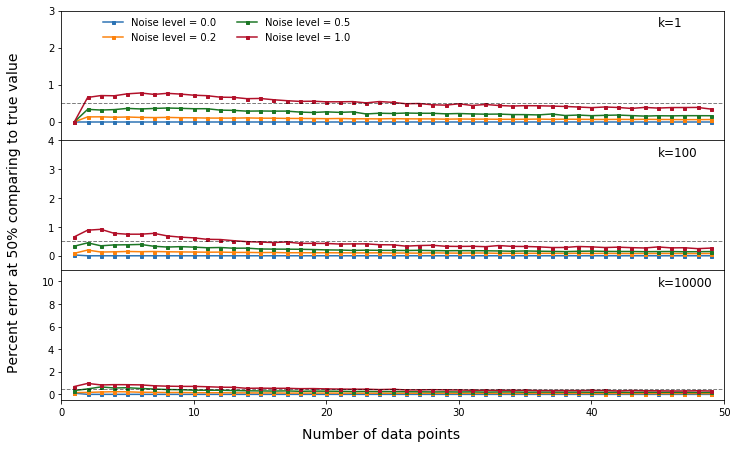

In [14]:
import util
print(util.color.BOLD + util.color.BLUE + \
'Boxplot for sampling methods' + util.color.END)

def median_abs_error(results, param='kA'):
    return np.median(np.abs(results[param + 'err']))

def e90_abs_error(results, param='kA'):
    return np.percentile(np.abs(results[param + 'err']), 50)

def plot_datasize(fittedParamL):
    import matplotlib.pyplot as plt
    
    sizeList = [i for i in range(50) if i>=1]
    fig,ax = plt.subplots(3,1, figsize=[10, 6], gridspec_kw = {'wspace':0, 'hspace':0})
    errList = [0.0, 0.2, 0.5, 1.0]
    colorList = ['#2C73B4', '#FC820D', '#1C7725', '#B2112A']
    ylimList = [3, 4, 11]
    
    for kIx,k in enumerate(kList):
        lines = []
        for errIx,err in enumerate(errList):
            ax[kIx].plot(
                sizeList,
                [e90_abs_error(fittingResults[re(k=k, A=0.5, err=err, avg=False, rep=1, size=i, smpl='log')]) for i in sizeList],
                marker='s', markersize=3, c=colorList[errIx], label= 'Noise level = %.1f'%err)
        ax[kIx].set_xlim([0, 50])
        ax[kIx].set_ylim([-0.5, ylimList[kIx]])
        ax[kIx].plot([0, 50], [0.5, 0.5], 'k--', alpha=0.5, lw=1)
        ax[kIx].text(s='k=%i'%(k), x=45, y=ylimList[kIx]*0.95, ha='left', va='top', fontsize=12)
        if kIx==0:
            ax[kIx].legend(bbox_to_anchor=(0.05, 0.85), loc='center left',ncol=2, frameon=False)
    
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    # ax[0].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    # ax[1].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    # xloc = [1.5, 4.5, 7.5, 10.5]
    # ax[2].set_xticks(xloc)
    # ax[2].set_xticklabels(['0', '0.2', '0.5', '1.0'], {'fontsize':12})
    # ax[2].set_yticks([-0.5, 0, 0.5, 1.0, 1.5])
    
    fig.text(s='Number of data points', x=0.5, y=0, ha='center', va='top', fontsize=14)
    fig.text(s='Percent error at 50% comparing to true value', x=0, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.tight_layout()
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/smpl_num_converge_50.jpeg', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_datasize(fittingResults)

# Bootstrap test
## Test bootstrap depth for convergence

In [55]:
import util
np.random.seed(23)

## fake sample with 10 counts in 5*10^6 total counts
k=10
sample = np.array([1 for i in range(k)] + [0 for i in range(5*10**6 - k)])
depthList = np.linspace(5, 2000, 40)
bsResList = []

for ix,depth in enumerate(depthList):
    resampled = [np.sum(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(int(depth))]
    bsResList.append([np.mean(resampled), np.std(resampled), [np.percentile(resampled, 10), np.percentile(resampled, 90)]])
    util.progress_bar(ix/len(depthList))

util.dump_pickle(bsResList, '/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/bootstrap_convergence.pkl',
                log='Test for bootstrap convergence, for k=10 in 5*10**6 sequence pool')

[====================] 97%

In [56]:
bsResList = util.load_pickle('/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/bootstrap_convergence.pkl')

Data has been saved to /mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/bootstrap_convergence.pkl


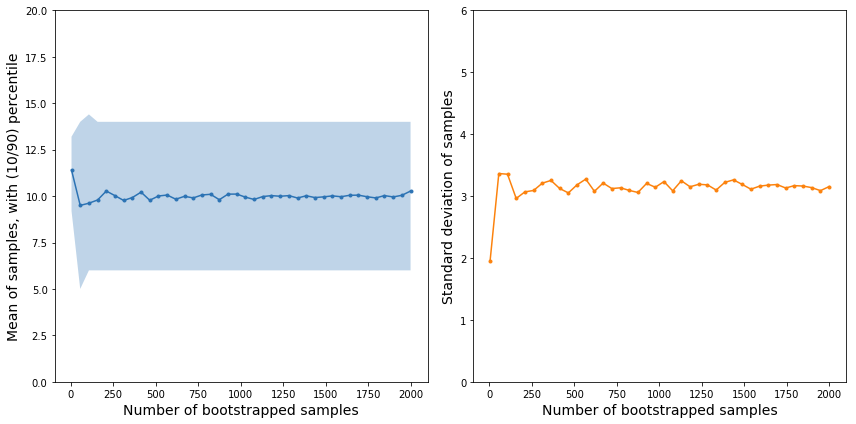

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].plot(depthList, [bsRes[0] for bsRes in bsResList], '.-', c='#2C73B4')
ax[0].fill_between(depthList, y1=[bsRes[2][0] for bsRes in bsResList],
               y2=[bsRes[2][1] for bsRes in bsResList], 
                alpha=0.3, facecolor='#2C73B4')
ax[0].set_ylabel('Mean of samples, with (10/90) percentile', fontsize=14)
ax[0].set_xlabel('Number of bootstrapped samples', fontsize=14)
ax[0].set_ylim([0, 20])

ax[1].plot(depthList, [bsRes[1] for bsRes in bsResList], '.-', c='#FC820D')
ax[1].set_xlabel('Number of bootstrapped samples', fontsize=14)
ax[1].set_ylabel('Standard deviation of samples', fontsize=14)
ax[1].set_ylim([0, 6])

plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/bs_convergence_test.jpeg', dpi=300, bbox_inches='tight')

plt.show()

In [15]:
import numpy as np
import util
np.random.seed(23)

totalList = [10**5, 10**6, 10**7]
seqCountList = [1, 10, 100, 1000, 10000]
bsDepth = 1000
bsResTab = []
for total in totalList:
    bsResBatch = []
    for ix,seqCount in enumerate(seqCountList):
        sample = np.array([1 for i in range(seqCount)] + [0 for i in range(total - seqCount)])
        resampled = [np.sum(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(bsDepth)]
        bsResBatch.append([np.mean(resampled), np.std(resampled, ddof=1), [np.percentile(resampled, 2.5), np.percentile(resampled, 97.5)]])
        util.progress_bar(ix/5)
    bsResTab.append(bsResBatch)

util.dump_pickle(bsResTab, '/mnt/storage/projects/k-seq/working/archive/fit_simu/seqFrac_bsTest_new.pkl',
                 log='Bootstrap test results for sequence fraction estimation, with bsDepth=1000', 
                overwrite=False)

Data has been saved to /mnt/storage/projects/k-seq/working/archive/fit_simu/seqFrac_bsTest_new.pkl


seqFrac_bsTest_new.pkl:
Bootstrap test results for sequence fraction estimation, with bsDepth=1000


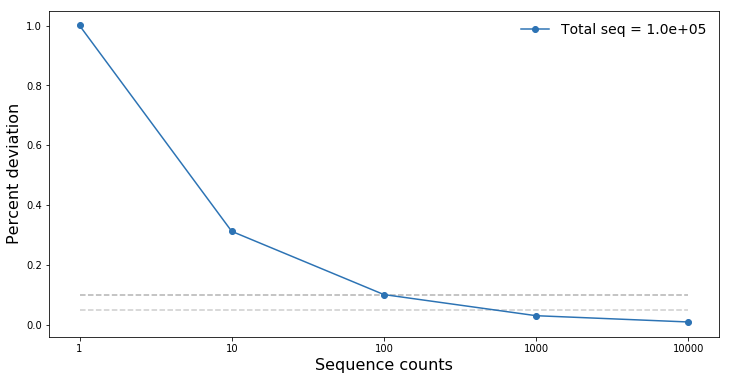

In [23]:
bsResTab = util.load_pickle(dirc='/mnt/storage/projects/k-seq/working/archive/fit_simu/seqFrac_bsTest_new.pkl')

pctDevList = [[seq[1]/seq[0] for seq in total] for total in bsResTab]

fig = plt.figure(figsize=(12,6))
ax = plt.subplot()

ax.plot([1, 5], [0.1, 0.1], 'k--', alpha=0.3)
ax.plot([1, 5], [0.05, 0.05], 'k--', alpha=0.2)

xPos = [1, 2, 3, 4, 5]
colorList = ['#2C73B4', '#FC820D', '#1C7725']
totalList = [10**5, 10**6, 10**7]
for ix,pctDev in enumerate(pctDevList[:1]):
    ax.plot(xPos, pctDev, 'o-', c=colorList[ix], label='Total seq = %.1e' %totalList[ix])


ax.set_ylabel('Percent deviation', fontsize=16)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_xlabel('Sequence counts', fontsize=16)

plt.legend(fontsize=14, frameon=False)

fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/bs_seqFrac.jpeg', dpi=300, bbox_inches='tight')
plt.show()

seqFrac_bsTest.pkl:
Bootstrap test results from sequence fraction estimation, with bsDepth=1000


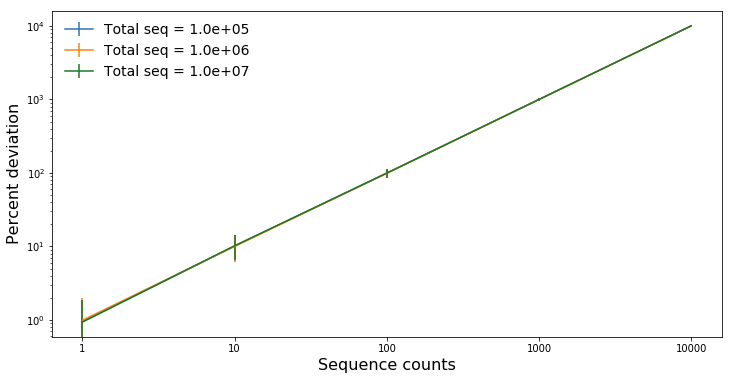

In [13]:
import matplotlib.pyplot as plt

bsResTab = util.load_pickle(dirc='/mnt/storage/projects/k-seq/working/archive/fit_simu/seqFrac_bsTest_new.pkl')

meanList = [[stat[0] for stat in counts] for counts in bsResTab]
upperList = [[stat[2][1] - stat[0] for stat in counts] for counts in bsResTab]
lowerList = [[stat[0] - stat[2][0] for stat in counts] for counts in bsResTab]

fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
xPos = [1, 2, 3, 4, 5]
colorList = ['#2C73B4', '#FC820D', '#1C7725']
totalList = [10**5, 10**6, 10**7]
for ix,means in enumerate(meanList):
    ax.errorbar(x=xPos, y=means, yerr=[upperList[ix], lowerList[ix]], color = colorList[ix], label='Total seq = %.1e' %totalList[ix])
    
ax.set_yscale('log')

ax.set_ylabel('Percent deviation', fontsize=16)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_xlabel('Sequence counts', fontsize=16)

plt.legend(fontsize=14, frameon=False)

# fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/bs_seqFrac.jpeg', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
bsResTab = util.load_pickle(dirc='/mnt/storage/projects/k-seq/working/archive/fit_simu/seqFrac_bsTest_new.pkl')

for batch in bsResTab:
    print("-----------------")
    for concen in batch:
        print("{}+{}".format(concen[0], 2*concen[1]))

seqFrac_bsTest_new.pkl:
Bootstrap test results for sequence fraction estimation, with bsDepth=1000
-----------------
1.01+2.020812629533892
9.877+6.175890674682124
100.337+20.344129561315903
1000.712+61.5837379571976
10001.793+195.7967133456457
-----------------
1.011+2.047366041456121
9.919+6.341132861403077
100.298+20.393839577006894
998.252+63.206178535053084
10001.452+200.8219316514813
-----------------
1.015+2.043349034128843
9.938+6.452461410830619
100.436+19.45358727993524
1000.332+63.26611814949378
9997.9+200.79643225716737


In [24]:
import numpy as np

# eg. seq A was detected 100 counts in 10**5 total reads
total_counts = 10**5
count_seq_A = 100
bootstrap_depth = 1000

# sample with 1 representing seq A and 0 representing other seqs
sample = np.array([1 for i in range(count_seq_A)] + [0 for i in range(total_counts - count_seq_A)])
bootstraped_counts = [np.sum(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(bootstrap_depth)]

# some related statistics
bootstraped_mean = np.mean(bootstraped_counts)
bootstraped_sd = np.std(bootstraped_counts, ddof=1)
bootstraped_median = np.percentile(bootstraped_counts, 50)
bootstraped_95CI = [np.percentile(bootstraped_counts, 2.5), np.percentile(bootstraped_counts, 97.5)]

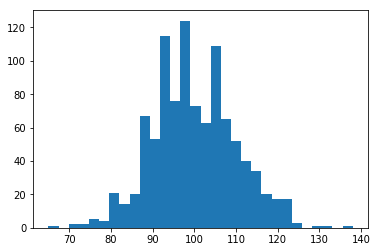

95% confidence interval is (82.0, 120.0)


In [29]:
import matplotlib.pyplot as plt
plt.hist(bootstraped_counts, bins=30)
plt.show()
print('95% confidence interval is ({}, {})'.format(*bootstraped_95CI))